In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import Model
from keras.layers import Dense,Input,Dropout
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras import regularizers
%matplotlib inline

In [2]:
sns.set(style='whitegrid',palette='muted',font_scale=1.5)
rcParams['figure.figsize']=10,6
RANDOM_SEED=42
LABELS=['Severity','Non Severity']

In [3]:
df=pd.read_csv('Diseases (1).csv')
df.head()


,Tiredness,Dry-Cough,Sore-Throat,Age_0-9,Severity,Non Severity
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,1,1,1,1,0,0
3,1,1,1,1,1,0
4,1,1,1,1,1,0


In [4]:
df.shape

(316800, 6)

In [5]:
df.isnull().values.any()

False

In [6]:
df.isna().sum().sum()

0

In [7]:
xtrain,xtest=train_test_split(df,test_size=0.2,random_state=RANDOM_SEED)

In [8]:
input_dim=xtrain.shape[1]
encoding_dim=14

In [9]:
input_layer=Input(shape=(input_dim,))
encoder=Dense(encoding_dim,activation='tanh',
              activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder=Dense(int(encoding_dim/2),activation='relu')(encoder)
decoder=Dense(int(encoding_dim/2),activation='tanh')(encoder)
decoder=Dense(input_dim,activation='relu')(decoder)
autoencoder=Model(inputs=input_layer,outputs=decoder)
input_layer=Input(shape=(input_dim,))
encoder=Dense(encoding_dim,activation='tanh',
              activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder=Dense(int(encoding_dim/2),activation='relu')(encoder)
decoder=Dense(int(encoding_dim/2),activation='tanh')(encoder)
decoder=Dense(input_dim,activation='relu')(decoder)
autoencoder=Model(inputs=input_layer,outputs=decoder)

In [10]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_4 (Dense)             (None, 14)                98        
                                                                 
 dense_5 (Dense)             (None, 7)                 105       
                                                                 
 dense_6 (Dense)             (None, 7)                 56        
                                                                 
 dense_7 (Dense)             (None, 6)                 48        
                                                                 
Total params: 307 (1.20 KB)
Trainable params: 307 (1.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
nb_epoch=20
batch_size=32
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer=ModelCheckpoint(filepath='model_ae.h5',
                             verbose=0,
                             save_best_only=True)

tensorboard=TensorBoard(log_dir='./logs',
                        histogram_freq=0,
                        write_graph=True,
                        write_images=True)

history=autoencoder.fit(xtrain,xtrain,
                       epochs=nb_epoch,
                       batch_size=batch_size,
                       shuffle=True,
                       validation_data=(xtest,xtest),
                       verbose=1,
                       callbacks=[checkpointer,tensorboard]).history


Epoch 1/20
7920/7920 [==============================] - 56s 7ms/step - loss: 0.0466 - accuracy: 0.6113 - val_loss: 0.0416 - val_accuracy: 0.5440
Epoch 2/20
  10/7920 [..............................] - ETA: 44s - loss: 0.0497 - accuracy: 0.6406 

C:\Users\Prakash Nani\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7920/7920 [==============================] - 51s 7ms/step - loss: 0.0418 - accuracy: 0.6179 - val_loss: 0.0415 - val_accuracy: 0.6261
Epoch 3/20
7920/7920 [==============================] - 52s 7ms/step - loss: 0.0418 - accuracy: 0.6249 - val_loss: 0.0415 - val_accuracy: 0.6732
Epoch 4/20
7920/7920 [==============================] - 51s 6ms/step - loss: 0.0418 - accuracy: 0.6262 - val_loss: 0.0415 - val_accuracy: 0.5295
Epoch 5/20
7920/7920 [==============================] - 51s 6ms/step - loss: 0.0418 - accuracy: 0.6293 - val_loss: 0.0415 - val_accuracy: 0.7598
Epoch 6/20
7920/7920 [==============================] - 52s 7ms/step - loss: 0.0418 - accuracy: 0.6280 - val_loss: 0.0415 - val_accuracy: 0.5797
Epoch 7/20
7920/7920 [==============================] - 49s 6ms/step - loss: 0.0418 - accuracy: 0.6244 - val_loss: 0.0415 - val_accuracy: 0.7493
Epoch 8/20
7920/7920 [==============================] - 50s 6ms/step - loss: 0.0417 - accuracy: 0.6245 - val_loss: 0.0415 - val_accuracy: 0.5

In [12]:
from keras.models import load_model
autoencoder=load_model('model_ae.h5')

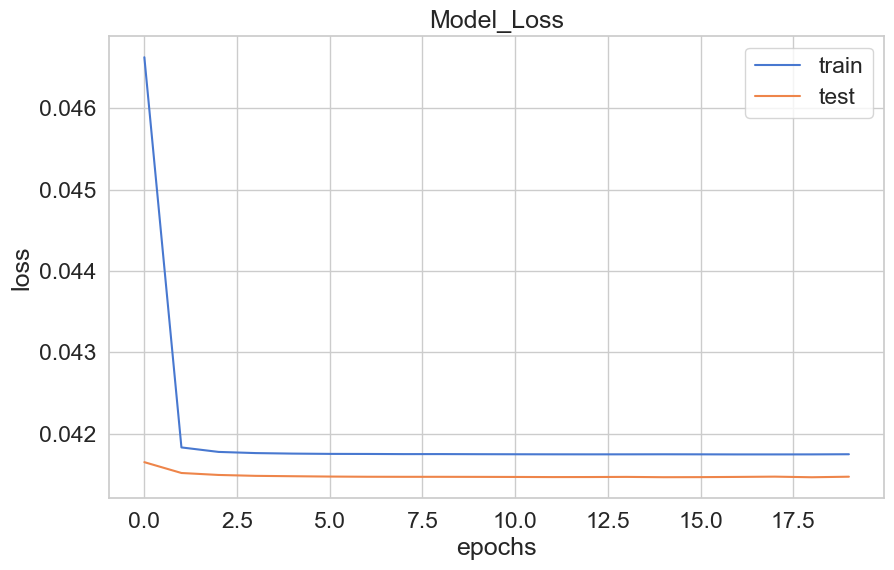

In [13]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model_Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','test'],loc='upper right')

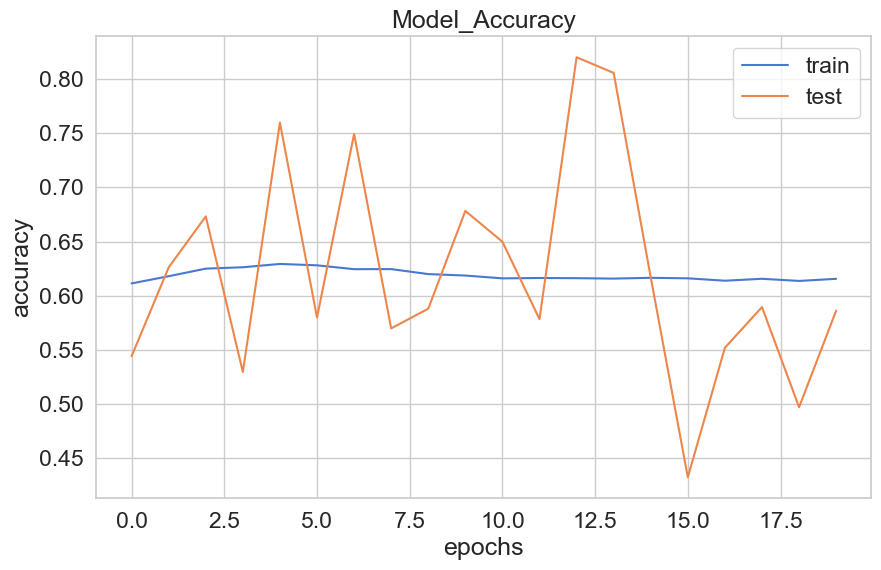

In [14]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model_Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','test'],loc='upper right')

In [16]:
predictions=autoencoder.predict(xtest)

1980/1980 [==============================] - 8s 4ms/step


In [25]:
print("Shape of xtest:", xtest.shape)
print("Shape of predictions:", predictions.shape)


Shape of xtest: (63360, 5)
Shape of predictions: (63360, 5)


In [24]:
predictions = predictions[:, :5]
mse = np.mean(np.power(xtest - predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'Severity': ytest})


In [26]:
mse=np.mean(np.power(xtest-predictions,2),axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'Severity': ytest})
print(error_df)

        Reconstruction_error  Severity
277936          2.007161e-01         1
193502          1.382736e-06         0
92446           2.000018e-01         0
117607          1.820684e-08         0
240924          4.110026e-08         0
...                      ...       ...
122340          2.770438e-07         0
151370          1.820684e-08         0
288434          1.382736e-06         0
1619            2.000017e-01         0
68501           2.007414e-01         1

[63360 rows x 2 columns]


In [27]:
error_df.describe()

,Reconstruction_error,Severity
count,6.336000e+04,63360.000000
mean,1.001146e-01,0.251089
std,1.001597e-01,0.433643
min,0.000000e+00,0.000000
25%,4.110026e-08,0.000000
50%,2.114308e-06,0.000000
75%,2.000047e-01,1.000000
max,2.010987e-01,1.000000


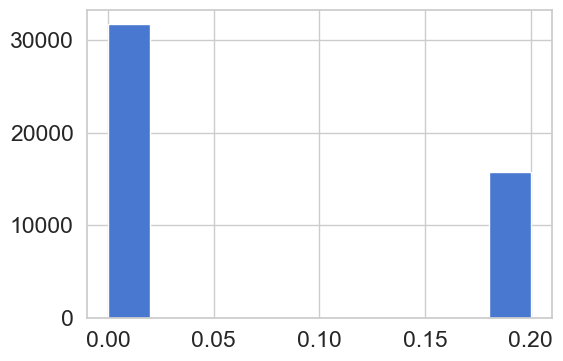

In [30]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
normal_error_df=error_df[(error_df['Severity']==0) & (error_df['Reconstruction_error']<1000)]
_=ax.hist(normal_error_df.Reconstruction_error.values,bins=10)

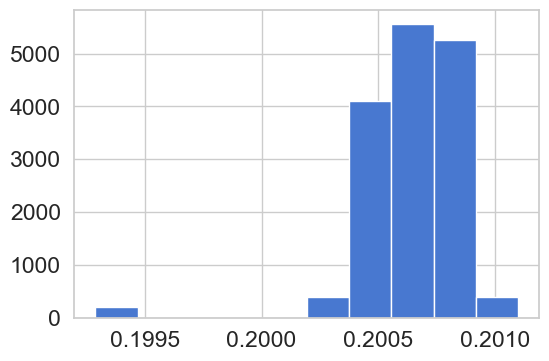

In [31]:
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
fraud_error_df=error_df[(error_df['Severity']==1)]
_=ax.hist(fraud_error_df.Reconstruction_error.values,bins=10)


In [32]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import precision_recall_curve,auc,roc_curve,recall_score,f1_score
from sklearn.metrics import precision_recall_fscore_support

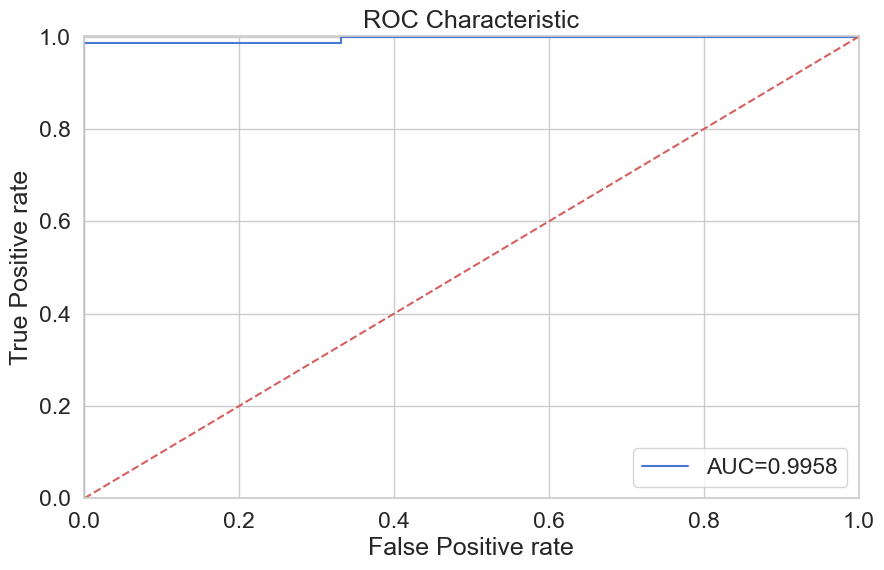

In [33]:
fpr,tpr,thresholds=roc_curve(error_df.Severity,error_df.Reconstruction_error)
roc_auc=auc(fpr,tpr)
plt.title('ROC Characteristic')
plt.plot(fpr,tpr,label='AUC=%0.4f'%roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001,1])
plt.ylim([0,1.001])
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.show()


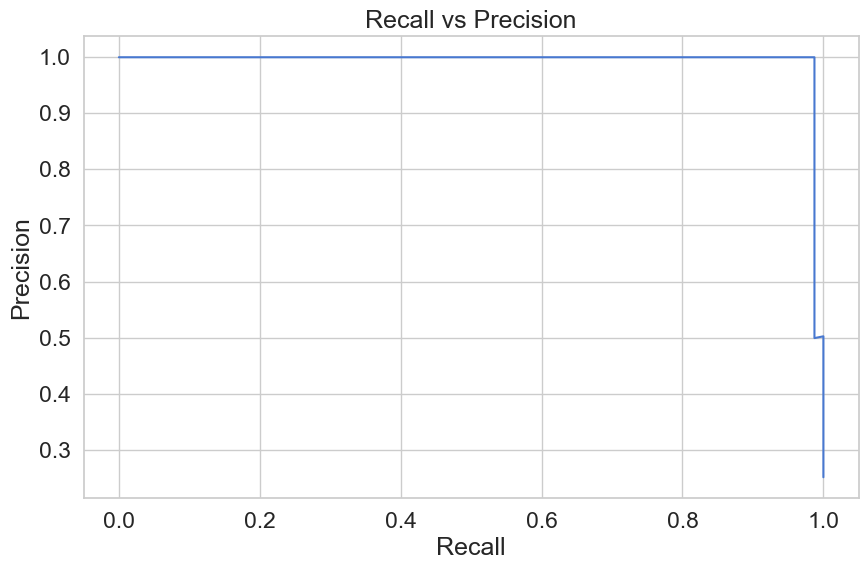

In [34]:
precision,recall,th=precision_recall_curve(error_df.Severity,error_df.Reconstruction_error)
plt.plot(recall,precision,'b',label='precision-recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

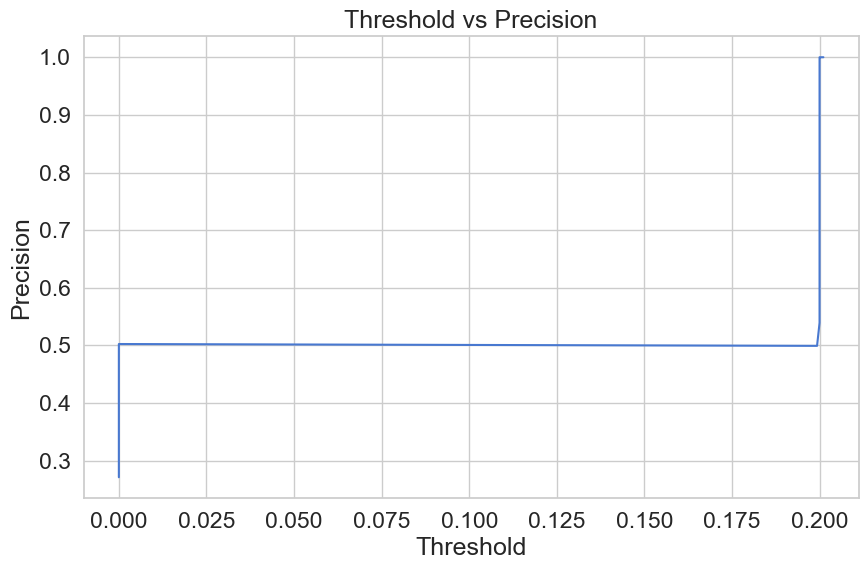

In [35]:
precision,recall,th=precision_recall_curve(error_df.Severity,error_df.Reconstruction_error)
plt.plot(th,precision[1:],'b',label='Threshold-precision curve')
plt.title('Threshold vs Precision')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

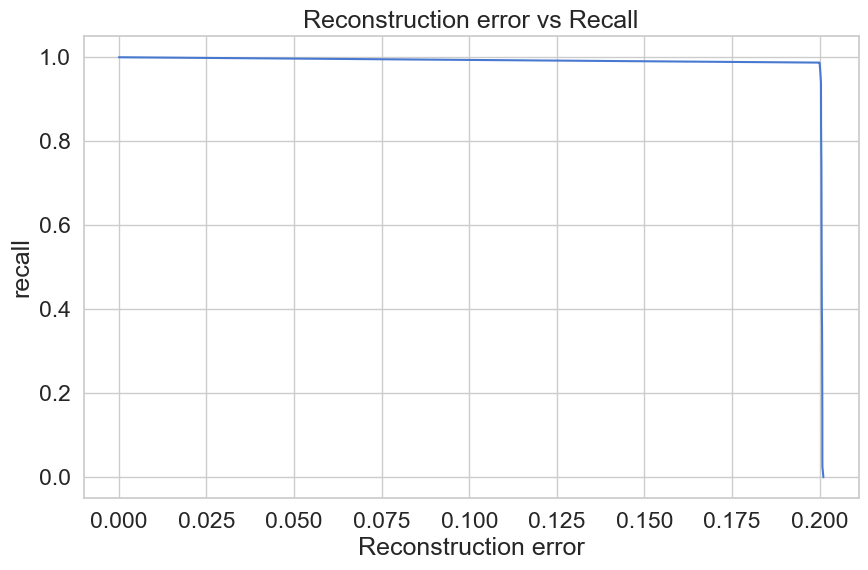

In [36]:
plt.plot(th,recall[1:],'b',label='Threshold-recall curve')
plt.title('Reconstruction error vs Recall')
plt.xlabel('Reconstruction error')
plt.ylabel('recall')
plt.show()

In [37]:
threshold=2.9

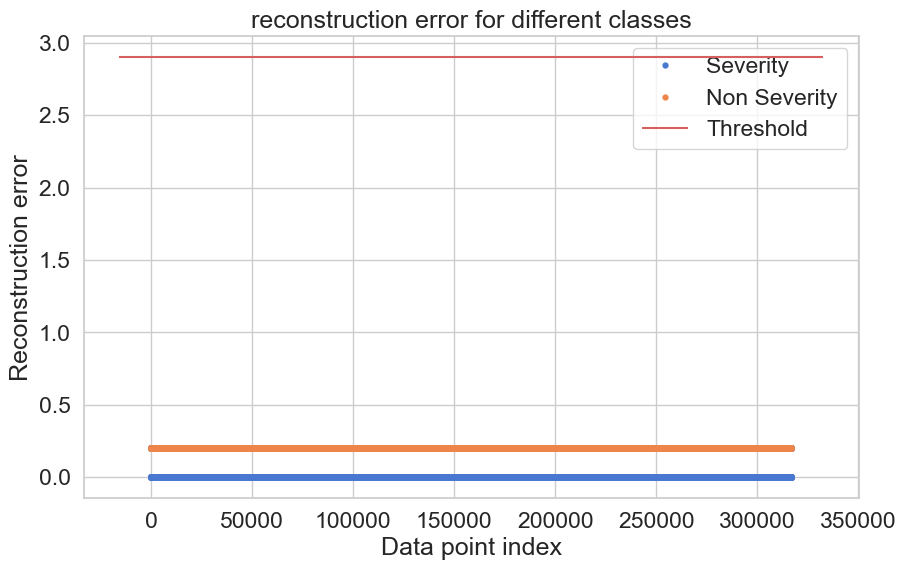

In [38]:
groups=error_df.groupby('Severity')
fig,ax=plt.subplots()
for name,group in groups:
    ax.plot(group.index,group.Reconstruction_error,marker='o',ms=3.5,linestyle='',
           label='Non Severity' if name ==1 else 'Severity')
ax.hlines(threshold,ax.get_xlim()[0],ax.get_xlim()[1],colors='r',zorder=100,label='Threshold')
ax.legend()
plt.title('reconstruction error for different classes')
plt.xlabel('Data point index')
plt.ylabel('Reconstruction error')
plt.show()


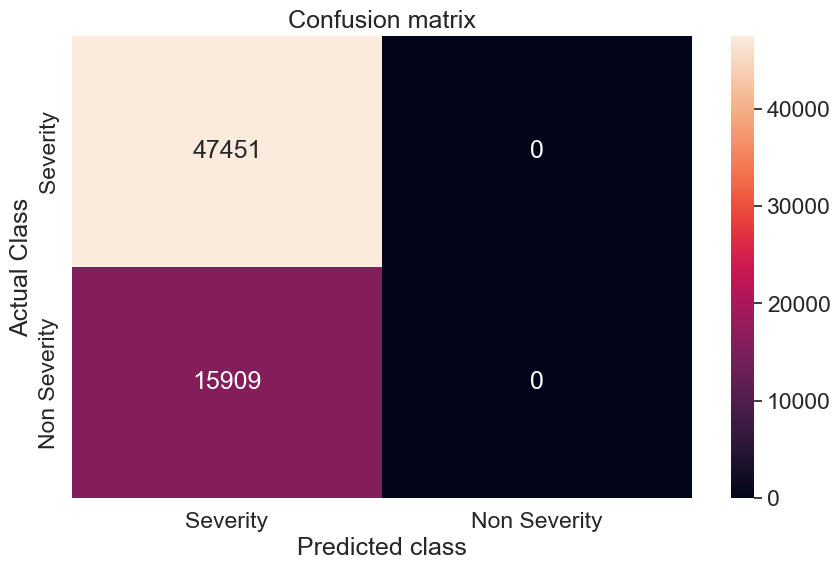

In [39]:
ypred=[1 if e>threshold else 0 for e in error_df.Reconstruction_error.values]
conf_matrix=confusion_matrix(error_df.Severity,ypred)
sns.heatmap(conf_matrix,annot=True,xticklabels=LABELS,yticklabels=LABELS,fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted class')
plt.ylabel('Actual Class')
plt.show()

In [43]:
import seaborn as sns
sns.heatmap(confusion_matrix(test_set,ypred),annot=True,xticklabels=['Severity','Non Severity'],
 yticklabels=['Severity','Non Severity'])

NameError: name 'test_set' is not defined